# Basic classification: Classify images of clothing
A tensorflow serving style service example using BentoML


![Impression](https://www.google-analytics.com/collect?v=1&tid=UA-112879361-3&cid=555&t=event&ec=tensorflow&ea=tensorflow_2_fashion_mnist&dt=tensorflow_2_fashion_mnist)

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

# add venv PATH to shell command PATH
import sys, os
if sys.base_prefix not in os.environ['PATH']:
    os.environ['PATH'] = f"{sys.base_prefix}/bin:{os.environ['PATH']}"

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import io

# TensorFlow
import tensorflow as tf

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


In [3]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(_train_images, train_labels), (_test_images, test_labels) = fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
train_images = _train_images / 255.0
test_images = _test_images / 255.0

In [42]:
class FashionMnist(tf.keras.Model):
    def __init__(self):
        super(FashionMnist, self).__init__()
        self.cnn = tf.keras.Sequential([
            tf.keras.layers.Flatten(input_shape=(28, 28)),
            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.Dense(10, activation='softmax')
        ])
    
    @staticmethod
    def image_bytes2tensor(inputs):
        inputs = tf.map_fn(lambda i: tf.io.decode_png(i, channels=1), inputs, dtype=tf.uint8)
        inputs = tf.cast(inputs, tf.float32)
        inputs = (255.0 - inputs) / 255.0
        inputs = tf.reshape(inputs, [-1, 28, 28])
        return inputs

    @tf.function(input_signature=[tf.TensorSpec(shape=(None,), dtype=tf.string)])
    def predict_image(self, inputs):
        inputs = self.image_bytes2tensor(inputs)
        return self(inputs)
    
    def call(self, inputs):
        return self.cnn(inputs)


## test the image preprocessing

Ankle boot


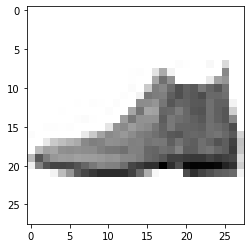

In [43]:
# pick up a test image
d_test_img = _test_images[0]
print(class_names[test_labels[0]])

plt.imshow(255.0 - d_test_img, cmap='gray')
plt.imsave("test.png", 255.0 - d_test_img, cmap='gray')

# read bytes
with open("test.png", "rb") as f:
    img_bytes = f.read()


## train the model


In [6]:
model = FashionMnist()
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels, epochs=1)

Train on 60000 samples
60000/60000 [==============================] - 6s 100us/sample - loss: 0.5038 - accuracy: 0.8234


## test the model

In [7]:
predict = model.predict_image(tf.constant([img_bytes] * 3))
klass = tf.argmax(predict, axis=1)
[class_names[k] for k in klass]

['Ankle boot', 'Ankle boot', 'Ankle boot']

And the model predicts a label as expected.

# Define & save BentoService

In [8]:
%%writefile tensorflow_fashion_mnist.py

import base64
import bentoml
import tensorflow as tf
import numpy as np
from PIL import Image

from bentoml.artifact import (
    TensorflowSavedModelArtifact,
)
from bentoml.handlers import TensorflowTensorHandler, ClipperStringsHandler


FASHION_MNIST_CLASSES = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


@bentoml.env(pip_dependencies=['tensorflow', 'numpy', 'pillow'])
@bentoml.artifacts([TensorflowSavedModelArtifact('model')])
class FashionMnistTensorflow(bentoml.BentoService):

    @bentoml.api(TensorflowTensorHandler)
    def predict(self, inputs):
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[o] for o in output_classes]

    @bentoml.api(ClipperStringsHandler)
    def predict_clipper(self, strings):
        _bytes = [base64.b64decode(i) for i in strings]
        inputs = tf.constant(_bytes, dtype=tf.string)
        outputs = self.artifacts.model.predict_image(inputs)
        output_classes = tf.math.argmax(outputs, axis=1)
        return [FASHION_MNIST_CLASSES[o] for o in output_classes]

Overwriting tensorflow_fashion_mnist.py


In [9]:
from tensorflow_fashion_mnist import FashionMnistTensorflow

bento_svc = FashionMnistTensorflow()
bento_svc.pack("model", model)
saved_path = bento_svc.save()

[2020-02-20 21:27:55,964] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml_deploy_version' to a pinned version or your custom BentoML on github, e.g.:'bentoml_deploy_version = git+https://github.com/{username}/bentoml.git@{branch}'
[2020-02-20 21:27:56,156] WARNING - BentoML local changes detected - Local BentoML repository including all code changes will be bundled together with the BentoService bundle. When used with docker, the base docker image will be default to same version as last PyPI release at version: 0.5.2. You can also force bentoml to use a specific version for deploying your BentoService bundle, by setting the config 'core/bentoml

no previously-included directories found matching 'examples'
no previously-included directories found matching 'tests'
no previously-included directories found matching 'docs'
no previously-included directories found matching 'scripts'


writing manifest file 'BentoML.egg-info/SOURCES.txt'
running check


creating BentoML-0.5.2+105.ga67aa5e.dirty
creating BentoML-0.5.2+105.ga67aa5e.dirty/BentoML.egg-info
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/artifact
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/bundler
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/cli
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/clipper
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/configuration
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/deployment
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/deployment/aws_lambda
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/deployment/sagemaker
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/handlers
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/marshal
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/migrations
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/migrations/versions
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentoml/proto
creating BentoML-0.5.2+105.ga67aa5e.dirty/bentom

In [36]:
tf_model_path = f"{saved_path}/FashionMnistTensorflow/artifacts"
!cp -r {tf_model_path}/model_saved_model {tf_model_path}/1

# Build & Run TF-Serving Service

In [ ]:
TMP_MODEL_DIR = "/tmp/test-model/"
TMP_MODEL_SAVE_DIR = "/tmp/test-model/1"
SERVE_HOST = "http://localhost:8890"
SERVE_PORT = 8890
MODEL_NAME = "fashion_model"
tf.saved_model.save(model, TMP_MODEL_SAVE_DIR, signatures=model.predict_image)
!tensorflow_model_server --rest_api_port={SERVE_PORT} --model_name={MODEL_NAME} --model_base_path={TMP_MODEL_DIR}

INFO:tensorflow:Assets written to: /tmp/test-model/1/assets
2020-02-20 22:06:10.831536: I tensorflow_serving/model_servers/server.cc:85] Building single TensorFlow model file config:  model_name: fashion_model model_base_path: /tmp/test-model/
2020-02-20 22:06:10.831673: I tensorflow_serving/model_servers/server_core.cc:462] Adding/updating models.
2020-02-20 22:06:10.831685: I tensorflow_serving/model_servers/server_core.cc:573]  (Re-)adding model: fashion_model
2020-02-20 22:06:10.932326: I tensorflow_serving/core/basic_manager.cc:739] Successfully reserved resources to load servable {name: fashion_model version: 1}
2020-02-20 22:06:10.932384: I tensorflow_serving/core/loader_harness.cc:66] Approving load for servable version {name: fashion_model version: 1}
2020-02-20 22:06:10.932413: I tensorflow_serving/core/loader_harness.cc:74] Loading servable version {name: fashion_model version: 1}
2020-02-20 22:06:10.932456: I external/org_tensorflow/tensorflow/cc/saved_model/reader.cc:31] R

# Run in Docker with 1 CPU

In [ ]:
!docker pull tensorflow/serving
!docker run -t --rm -p {SERVE_PORT}:8501 -v {TMP_MODEL_DIR}:/models/{MODEL_NAME} -e MODEL_NAME={MODEL_NAME} --cpus 1 tensorflow/serving

# Test with requests

In [23]:
import base64
import json
import requests

with open("test.png", "rb") as f:
    img_bytes = f.read()
img_b64 = base64.b64encode(img_bytes).decode()


headers = {"content-type": "application/json"}
data = json.dumps(
       {"instances": [{"b64": img_b64}]}
)

json_response = requests.post(f"http://127.0.0.1:{SERVE_PORT}/v1/models/fashion_model:predict", data=data, headers=headers)
print(json_response)
print(json_response.text)

<Response [200]>
{"query_id":1,"output":"Ankle boot","default":false}


# Test with requests

In [48]:
import base64
import json
import requests

with open("test.png", "rb") as f:
    img_bytes = f.read()
img_b64 = base64.b64encode(img_bytes).decode()


headers = {"content-type": "application/json"}
data = json.dumps(
       {"instances": [{"b64": img_b64}]}
)

json_response = requests.post(
    f"http://127.0.0.1:{SERVE_PORT}/v1/models/fashion_model:predict",
    data=data, headers=headers)
print(json_response)
print(json_response.text)

<Response [200]>
["Ankle boot", "Ankle boot", "Ankle boot"]


# Benchmark with locust

In [ ]:
%%writefile benchmark_serving.py
from locust import HttpLocust, TaskSet, task, constant
from functools import lru_cache

import math
import random
import numpy as np
import pandas as pd
import json
import base64
import requests


@lru_cache(maxsize=1)
def data_producer():

    with open("test.png", "rb") as f:
        img_bytes = f.read()
    img_b64 = base64.b64encode(img_bytes).decode()

    def _gen_data(size=3):
        headers = {"content-type": "application/json"}
        data = json.dumps(
               {"instances": [{"b64": img_b64}] * size}
        )
        return headers, data

    return _gen_data


class WebsiteTasks(TaskSet):

    @staticmethod
    def get_data():
        headers, data = data_producer()(3)
        return headers, data
        
    @task
    def index(self):
        headers, data = self.get_data()
        self.client.post("/v1/models/fashion_model:predict", data, headers=headers)

class WebsiteUser(HttpLocust):
    task_set = WebsiteTasks
    wait_time = constant(1)

In [ ]:
!locust -f benchmark_serving.py -H http://127.0.0.1:{SERVE_PORT}

[2020-02-20 22:06:34,066] beta/INFO/locust.main: Starting web monitor at http://*:8089
[2020-02-20 22:06:34,066] beta/INFO/locust.main: Starting Locust 0.14.4
[2020-02-20 22:06:52,249] beta/INFO/locust.runners: Hatching and swarming 1000 users at the rate 20 users/s (0 users already running)...
[2020-02-20 22:07:49,144] beta/WARNING/root: Loadgen CPU usage above 90%! This may constrain your throughput and may even give inconsistent response time measurements! See https://docs.locust.io/en/stable/running-locust-distributed.html for how to distribute the load over multiple CPU cores or machines
[2020-02-20 22:07:51,659] beta/INFO/locust.runners: All locusts hatched: WebsiteUser: 1000 (0 already running)
